In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats


 # Loading the Data

In [2]:
# Load from Disk or from Web
LOAD_FROM_WEB = False
if LOAD_FROM_WEB:
    CURRENT_TICKERS = ["ALV", "AAPL", "ATTB34.SA", "EVD.DE",
                       "DLR", "O", "KRN.DE", "RYAAY", "VEUR.AS", "IQQ6.DE", "SPY"]
    NEW_TICKERS = ["LOR.F", "PG", "UL", "MMM",
                   "BLK", "PBB.DE", "SIX3.DE", "BRK-B"]

    ALL_TICKERS = CURRENT_TICKERS + NEW_TICKERS

    dfs = []
    for ticker in ALL_TICKERS:
        dfs.append(pd.DataFrame(yf.Ticker(ticker).history("5y")[
                   "Close"]).rename({"Close": (ticker)}, axis=1))
    stocks = pd.concat(dfs, axis=1)
else:
    stocks = pd.read_pickle("stocksdf.pickle")

# Create Scaled prices
stocks_scaled = stocks/stocks.loc["2015-03-19"]

# Create Returns DF
returns = stocks.pct_change()


 # Plot Scaled Prices

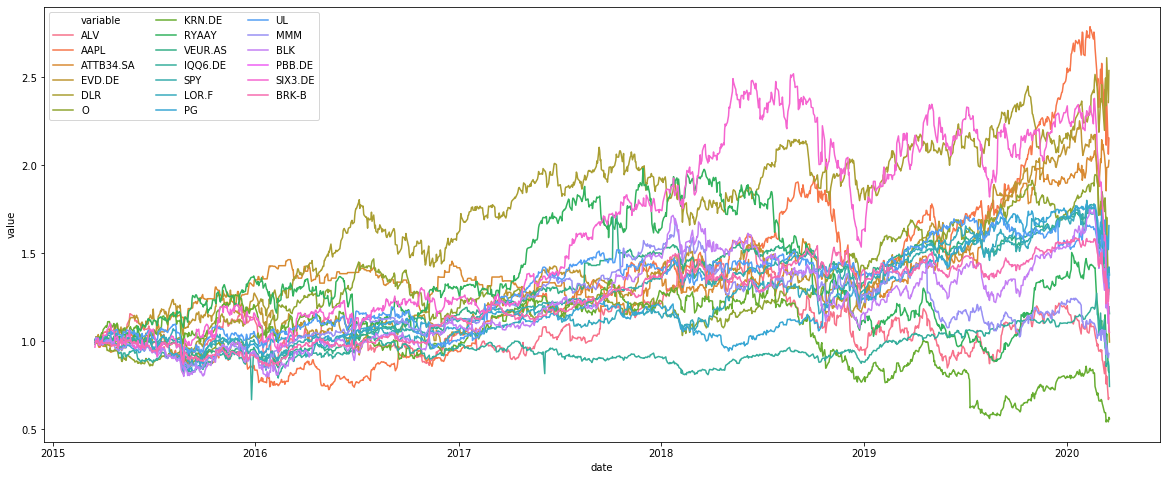

In [3]:
# Melt df to have long format favoured by seaborn
plot_stocks = stocks_scaled.copy()
plot_stocks["date"] = plot_stocks.index
plot_stocks = plot_stocks.melt(id_vars="date")

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(data=plot_stocks, x="date", y="value", hue="variable")
plt.legend(ncol=3)
plt.show()


 # Plot Correlation of Returns

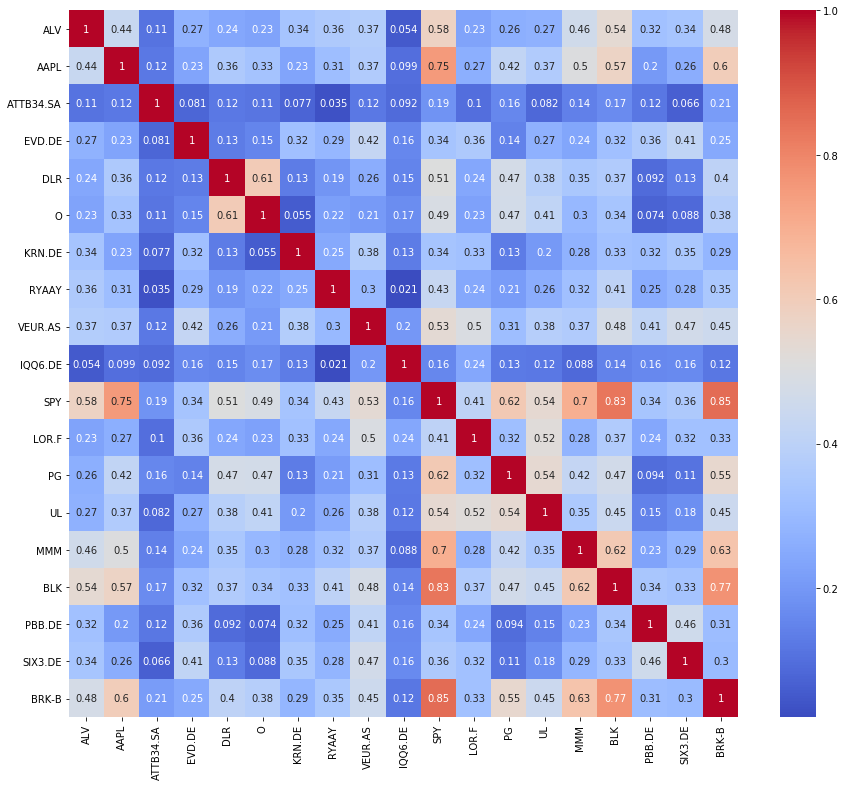

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(15, 13))
sns.heatmap(returns.corr(), annot=True, ax=axes, cmap="coolwarm")


 # Stock Returns are t-distribuited

Text(-0.12, 40, 'MLE fit $\\mathcal{t}$(1.99) with \nloc=0.0007, \nscale=0.0046')

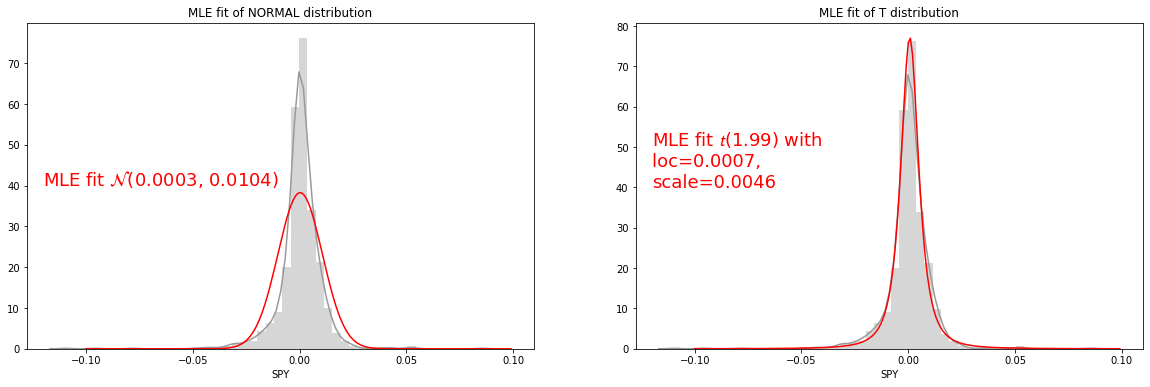

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
# MLE for normal distribution
loc_norm, scale_norm = stats.norm.fit(returns["SPY"].dropna())
norm_spy = stats.norm(loc=loc_norm, scale=scale_norm)

# MLE for t-distribution
df_t, loc_t, scale_t = stats.t.fit(returns["SPY"].dropna())
t_spy = stats.t(df=df_t, loc=loc_t, scale=scale_t)

# Plot Normal fit
sns.distplot(returns["SPY"], ax=axes[0], color="0.6")
axes[0].plot(np.arange(-0.1, 0.1, 0.001), norm_spy.pdf(np.arange(-0.1, 0.1, 0.001)), color="red")
axes[0].set_title("MLE fit of NORMAL distribution")
axes[0].annotate(r"MLE fit $\mathcal{N}$"+f"({np.round(loc_norm, 4)}, {np.round(scale_norm, 4)})", (-0.12, 40), color="red", size=18)

# Plot t fit
sns.distplot(returns["SPY"], ax=axes[1], color="0.6")
axes[1].plot(np.arange(-0.1, 0.1, 0.001), t_spy.pdf(np.arange(-0.1, 0.1, 0.001)), color="red")
axes[1].set_title("MLE fit of T distribution")
axes[1].annotate(r"MLE fit $\mathcal{t}$"+f"({np.round(df_t, 2)}) with \nloc={np.round(loc_t,4)}, \nscale={np.round(scale_t, 4)}", (-0.12, 40), color="red", size=18)


 ## Kolmogorov-Smirnov-Test for goodness of fit
 $H_0:$ Observed distribution $F(x)$ is identical to given distribution $G(x)$

In [6]:
print("== Normal-Distribution ==")
print(stats.kstest(returns["SPY"].dropna(), norm_spy.cdf))
print()
print("== T-Distribution ==")
print(stats.kstest(returns["SPY"].dropna(), t_spy.cdf))

== Normal-Distribution ==
KstestResult(statistic=0.15008988060804562, pvalue=6.81962789280766e-26)

== T-Distribution ==
KstestResult(statistic=0.0363616826000549, pvalue=0.06388595118717706)
